<a href="https://colab.research.google.com/github/dennisovich29/Automatic-Drug-Dispenser-Android-App/blob/main/Time_Series_ML_Project_Predicting_Closing_stock_price_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf

In [40]:
df=yf.download('AAPL',start='2015-12-03',end='2025-06-10')
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-12-03,26.028704,26.387955,25.807280,26.333729,166278000
2015-12-04,26.894070,26.943778,26.008371,26.049041,231108000
2015-12-07,26.724613,27.081605,26.618419,26.882775,128336800
2015-12-08,26.713316,26.796914,26.403773,26.552894,137238000
2015-12-09,26.123608,26.591311,26.001598,26.580013,185445600


In [41]:
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2392 entries, 2015-12-03 to 2025-06-09
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2392 non-null   float64
 1   High    2392 non-null   float64
 2   Low     2392 non-null   float64
 3   Close   2392 non-null   float64
 4   Volume  2392 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 112.1 KB


In [43]:
import numpy as np
import pandas as pd
df['Return']=np.log(df['Close'] / df['Close'].shift(1))
df['Ma_5'] = df['Close'].rolling(window=5).mean()
df['Ma_20'] = df['Close'].rolling(window=20).mean()
df['Volatility_5']=df['Return'].rolling(window=5).std()
df['Target'] = df['Close'].shift(-1)

In [44]:
features = ['Open', 'High', 'Low','Volume','Return','Ma_5','Ma_20','Volatility_5']

In [45]:
df.dropna(inplace=True)


In [46]:
df.head(10)

,Open,High,Low,Close,Volume,Return,Ma_5,Ma_20,Volatility_5,Target
Date,,,,,,,,,,
2015-12-31,23.782827,24.182747,23.683412,24.178229,163649200,-0.014565,24.363050,25.242649,0.014974,23.184078
2016-01-04,23.803164,23.807683,23.046253,23.184078,270597600,-0.041987,24.074294,25.085167,0.020464,23.893542
2016-01-05,23.206673,23.916136,23.138891,23.893542,223164000,0.030142,23.991148,24.977392,0.027769,22.720890
2016-01-06,22.752522,23.129849,22.564990,22.720890,273829600,-0.050323,23.701940,24.769297,0.034931,22.296118
2016-01-07,21.792263,22.623736,21.787745,22.296118,324377600,-0.018872,23.254571,24.556459,0.031401,22.266745
2016-01-08,21.907494,22.393273,21.862306,22.266745,283192000,-0.001318,22.872274,24.340795,0.032424,22.361646
2016-01-11,22.262230,22.381980,21.993356,22.361646,198957600,0.004253,22.707788,24.147953,0.029816,22.718627
2016-01-12,22.585320,22.750259,22.332262,22.718627,196616800,0.015838,22.472805,23.982561,0.025743,22.666665
2016-01-13,22.004650,22.863237,21.984316,22.666665,249758400,-0.002290,22.461960,23.848577,0.012559,22.133443


In [47]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume','Return','Ma_5','Ma_20','Volatility_5']])

scaled_df = pd.DataFrame(scaled_data, columns=['Open', 'High', 'Low', 'Close', 'Volume','Return','Ma_5','Ma_20','Volatility_5'], index=df.index)

In [48]:
target_original = df['Target'].values.reshape(-1,1)

close_scaler = MinMaxScaler()
close_scaler.fit(target_original)  # fit on original data once

df['Target_scaled'] = close_scaler.transform(target_original)



In [49]:
# X is the input features
X = scaled_df[['Open', 'High', 'Low', 'Volume', 'Return', 'Ma_5', 'Ma_20', 'Volatility_5']].values

# y is the scaled target
y = df['Target_scaled'].values.reshape(-1,1)

# Train-test split (80%-20%)
split_index = int(len(df) * 0.8)

x_train = X[:split_index]
x_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))  # (no_of_values, timestamps , features)
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))     # (n_test, 1, 8)

In [50]:
x_train.shape

(1897, 1, 8)

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout

In [52]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1,8)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=32,activation='relu'))
model.add(Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [53]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
history = model.fit(x_train, y_train, epochs=100, batch_size=16)

Epoch 1/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0489
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.1386e-04
Epoch 7/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.4829e-04
Epoch 8/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1608e-04
Epoch 9/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.6878e-04
Epoch 10/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.0279e-04
Epoch 11/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2875e-04
Epoch 12/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.1918e-04
Epoch 13/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.9048e-04
Epoch 14/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2501e-04
Epoch 1

In [55]:
pred = model.predict(x_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [56]:
print(pred.shape)
print(y_test.shape)

(475, 1)
(475, 1)


In [57]:
pred_inverse = close_scaler.inverse_transform(pred)
y_test_true = close_scaler.inverse_transform(y_test)

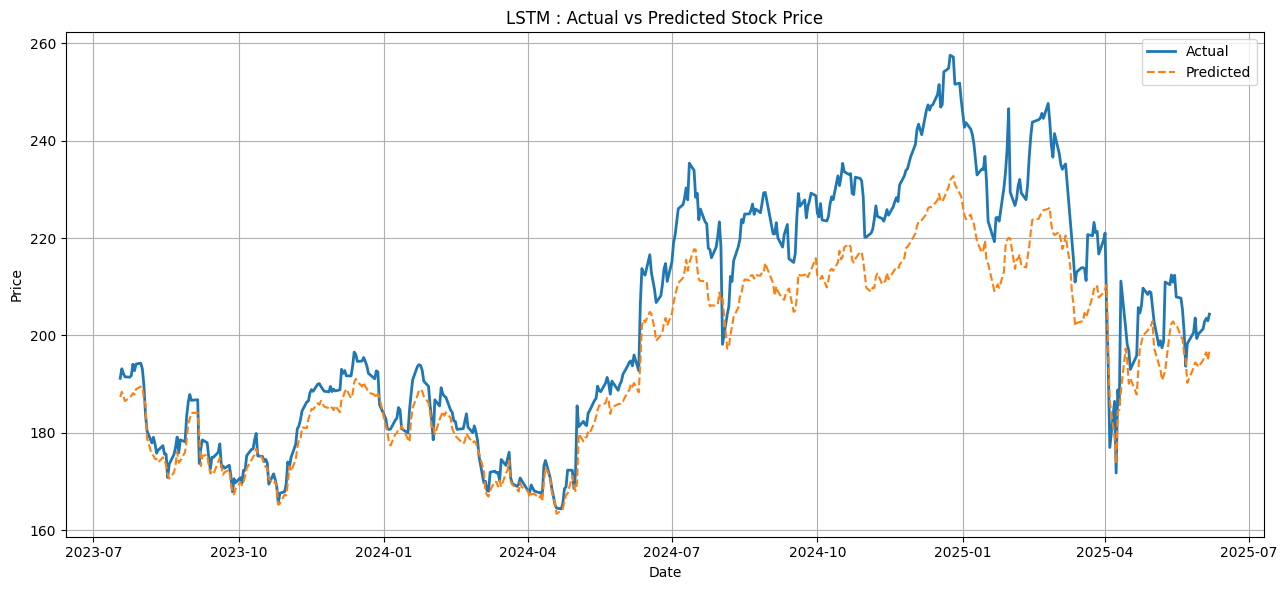

In [58]:
import matplotlib.pyplot as plt

test_dates = df.index[-len(y_test):]
plt.figure(figsize=(13,6))
plt.plot(test_dates, y_test_true.flatten(), label='Actual', linewidth=2)
plt.plot(test_dates, pred_inverse.flatten(), label='Predicted', linestyle='--')
plt.title('LSTM : Actual vs Predicted Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# MICRON STOCKS

In [59]:
df1=yf.download('MU',start='2010-12-9')
df1.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MU,MU,MU,MU,MU
Date,,,,,
2010-12-09,8.006721,8.143588,7.918735,8.143588,30057700
2010-12-10,8.065379,8.133812,7.889407,8.016498,31090800
2010-12-13,7.957841,8.192470,7.957841,8.192470,28082700
2010-12-14,7.889406,8.006721,7.820973,7.967616,25962700
2010-12-15,7.742763,7.928511,7.703658,7.820973,20301400


In [60]:
df1.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

import numpy as np
import pandas as pd

df1['Return']=np.log(df1['Close'] / df1['Close'].shift(1))
df1['Ma_5'] = df1['Close'].rolling(window=5).mean()
df1['Ma_20'] = df1['Close'].rolling(window=20).mean()
df1['Volatility_5']=df1['Return'].rolling(window=5).std()
df1['Target'] = df1['Close'].shift(-1)

features = ['Open', 'High', 'Low','Volume','Return','Ma_5','Ma_20','Volatility_5']

df1.dropna(inplace=True)


from sklearn.preprocessing import MinMaxScaler

tscaler = MinMaxScaler()
scaled_data = tscaler.fit_transform(df1[['Open', 'High', 'Low', 'Close', 'Volume','Return','Ma_5','Ma_20','Volatility_5']])

scaled_df1 = pd.DataFrame(scaled_data, columns=['Open', 'High', 'Low', 'Close', 'Volume','Return','Ma_5','Ma_20','Volatility_5'], index=df1.index)

target_original = df1['Target'].values.reshape(-1,1)

tclose_scaler = MinMaxScaler()
tclose_scaler.fit(target_original)  # fit on original data once

df1['Target_scaled'] = tclose_scaler.transform(target_original)

# X is the input features
X = scaled_df1[['Open', 'High', 'Low', 'Volume', 'Return', 'Ma_5', 'Ma_20', 'Volatility_5']].values

# y is the scaled target
y = df1['Target_scaled'].values.reshape(-1,1)

X=X.reshape((X.shape[0], 1, X.shape[1]))


In [61]:
pred2=model.predict (X)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [62]:
pred2 = tclose_scaler.inverse_transform(pred2)
y = tclose_scaler.inverse_transform(y)

In [63]:
print(pred2.shape)
print(y.shape)

(3628, 1)
(3628, 1)


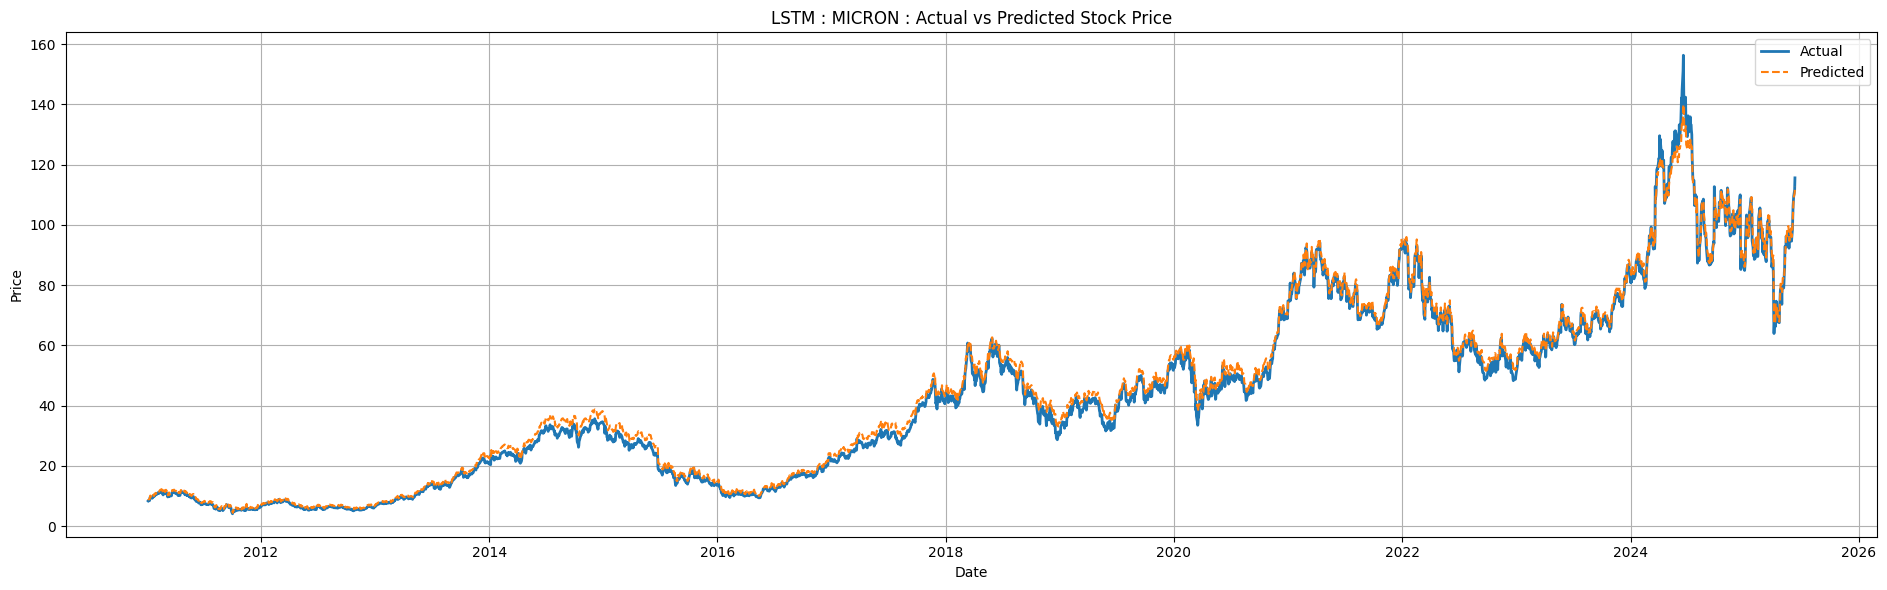

In [64]:
import matplotlib.pyplot as plt

test_dates = df1.index[-len(y):]
plt.figure(figsize=(19,6))
plt.plot(test_dates, y.flatten(), label='Actual', linewidth=2)
plt.plot(test_dates, pred2.flatten(), label='Predicted', linestyle='--')
plt.title('LSTM : MICRON : Actual vs Predicted Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
